# Modules

In [1]:
import sys 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pybandstructure
print('pybandstructure version = {}'.format(pybandstructure.__version__))
if pybandstructure.__version__ != '2.0rc0':
    print('please switch to version 2.0rc0')
    
from pybandstructure import *

import graphene as gr

pybandstructure version = 2.0rc0


# Parameters

In [2]:
########################################################################
#################### graphene parameters ###############################
########################################################################
#distances in nm, energies in eV
E_SQUARED = 1.4399764 # e^2 [ev *nm]
a = 0.246 #[nm] lattice constant of graphene
hv = 0.658 #hbar v_D [eV*nm]
########################################################################
################### moiré parameters ###################################
########################################################################
theta = 1.08 #twist angle [deg]
uAB = 0.0 #AB interlayer coupling [eV]
uAA = 0.0  #AA interlayer coupling [eV]
uAB_nl = -0.*uAB  #AB non-local interlayer coupling [eV]
uAA_nl = -0.*uAA  #AA non-local interlayer coupling [eV]
valley = 1
filling_factor = 0.25
temperature = 0.005 #k_B T [eV]
########################################################################
#################### computational parameters ##########################
########################################################################
n_sites = 18# number of unit cells of the crystal in one direction 
G_max = 3.001 #number of shells considered in reciprocal space
eta = 0.001 #energy smoothing [eV]
########################################################################
####################### output folder ##################################
########################################################################
output_folder = 'test_output'
file_name = 'tblg'

# Model

In [3]:
model = koshino(valley = valley, 
                uAA = uAA, 
                uAB = uAB, 
                uAA_nl = uAA_nl, 
                uAB_nl = uAB_nl,
                theta = theta, 
                hv = hv, 
                a = a, 
                G_max = G_max
               )
## length of smallest reciprocal vector
g = np.linalg.norm(model['reciprocal_lattice_vectors'].get_coords((1,0)))
n_bands = 4# * len(model['reciprocal_lattice_vectors'])

# Geometry

In [4]:
########################################################################
######################## Point group ###################################
########################################################################
#point_group = Point_Group.dihedral_group(
#    n = 3,
#    theta0 = np.arctan2(model['reciprocal_lattice_vectors'].basis_vectors[1,0], 
#                        model['reciprocal_lattice_vectors'].basis_vectors[0,0]))
point_group = Point_Group.trivial_group(space_dimension=2)
########################################################################
####################### Full geometry ##################################
########################################################################
lattice_geometry = Crystal_Geometry(
    reciprocal_lattice_basis = model['reciprocal_lattice_vectors'].basis_vectors, 
    point_group = point_group)
########################################################################
#################### Special points ####################################
########################################################################
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)
special_points = {'$\Gamma$': (0, 0), 
                  '$M$': (Mxy, 0), 
                  '$M^\prime$': (0, Mxy), 
                  '$K$': (Kxy, Kxy)}
########################################################################
########### Translate filling factor to density ########################
########################################################################
density = 4* filling_factor /lattice_geometry.unit_cell_volume

# Sampling of reciprocal space

C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


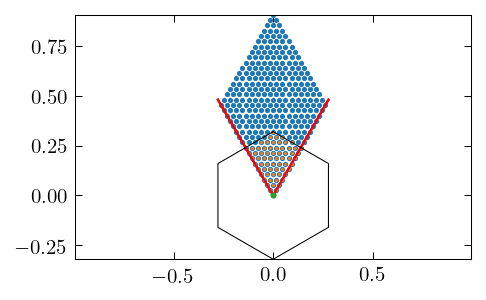

In [5]:
########################################################################
##################### k-sample #########################################
########################################################################
k_sample = Unit_Cell_Sample.default_unit_cell(
    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
    denominator=n_sites,
    special_points = special_points)
########## Reduced sample ########################
#k_sample = Unit_Cell_Sample.irreducible_wigner_seitz_cell(
#    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#    denominator=n_sites, 
#    point_group = point_group, 
#    special_points = special_points)
##### Precompiled sample #########################
#k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
#                                              basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites)
########################################################################
##################### q-sample #########################################
########################################################################
#q_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites,
#                                              special_points = special_points)
#q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites, special_points=special_points)
q_sample = Unit_Cell_Sample.irreducible_sample(
    name = '2D_Hexagonal_D3_Axes',
    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
    denominator=n_sites)
########################################################################
##################### G-sample #########################################
########################################################################
G_sample = Sample.lattice_sample(
    basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, 
    cut_off=g * 0.0001)
########################################################################
k_sample.plot(ms = 2.5)
q_sample.plot(ms = 1.5)
G_sample.plot(ms = 3)
plt.plot([g/np.sqrt(3) * np.sin(np.pi * angle/3) for angle in range(7)],
         [g/np.sqrt(3) * np.cos(np.pi * angle/3) for angle in range(7)],'k',lw=0.5)

# Scalar potential

In [ ]:
Defines two operators 
$U_S = 1/6 

In [6]:
first_shell_1 = [(1,0), (0,-1),(-1,1)]
first_shell_2 = [(-1,0),(0,1),(1,-1)]
potential_components_S = np.zeros([len(model['reciprocal_lattice_vectors'])], dtype = complex)
for key in first_shell_1:
    potential_components_S[model['reciprocal_lattice_vectors'][key]] = 1./6.
for key in first_shell_2:
    potential_components_S[model['reciprocal_lattice_vectors'][key]] = 1./6.

US = build_potential_hamiltonian(U = np.eye(4, dtype = complex), 
                                  potential_components = potential_components_S, 
                                  reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'])
#########################################################################################################################
potential_components_A = np.zeros([len(model['reciprocal_lattice_vectors'])], dtype = complex)
for key in first_shell_1:
    potential_components_A[model['reciprocal_lattice_vectors'][key]] = -1.j/6
for key in first_shell_2:
    potential_components_A[model['reciprocal_lattice_vectors'][key]] = 1.j/6
UA = build_potential_hamiltonian(U = np.eye(4, dtype = complex), 
                                  potential_components = potential_components_A, 
                                  reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'])

# Density operator

In [7]:
density_operator = [
    build_density_operator(matrix = np.eye(4), G = G,reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'], difference_vectors = None)
for G in G_sample]

# Non-interacting bands

In [8]:
aux_bs = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 hamiltonian = model['hamiltonian'],
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = 0,
                                                 temperature = temperature)

In [9]:
aux_bs.compute_bands(eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                         4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1))

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:19<00:00, 16.86it/s]


In [10]:
ns0 = aux_bs.average_operator(US)
na0 = aux_bs.average_operator(UA)

100%|███████████████████████████████████████████████████████████████████████████████| 324/324 [00:02<00:00, 124.66it/s]


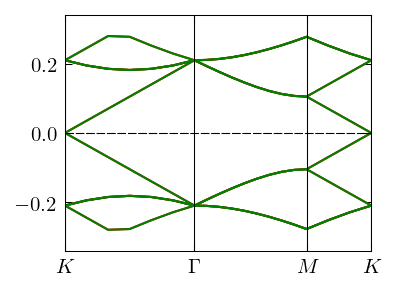

In [11]:
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = aux_bs.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c='r')
_ = aux_bs.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'],c='g')


# Full band structure

In [12]:
band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = model['hamiltonian'],
                                                 momentum_operator = model['momentum_operator'],
                                                 density_operator = density_operator,
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = density,
                                                 temperature = temperature)
tblg = Crystal(band_structure=band_structure, geometry=lattice_geometry, eta = eta)

In [13]:
eps_sub = 10.
alpha = 2. *np.pi * E_SQUARED / (g * eps_sub)

In [14]:
print(ns0, na0)
chi_0 = 2. * np.real(gr.chi(omega = 0, q = g, Ef= aux_bs.chemical_potential))
eps_0 = 1-chi_0 *alpha

0.0 0.0


In [15]:
tblg.band_structure.compute_sc_bands(
    operators = [US, UA], 
    transfer_function = lambda x:[np.real(6. * alpha * (x[0]-ns0)), np.real(6. * alpha * (x[1]-na0))], 
    ### Note that density calculated at 0 chemical potential is subtracted
    initial_values = [0, 0],
    eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                         4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1),
    options ={'method' : 'broyden1',
              'callback' : print,})

100%|███████████████████████████████████████████████████████████████████████████████| 324/324 [00:02<00:00, 133.75it/s]


     fun: array([0., 0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 1
  status: 1
 success: True
       x: array([0., 0.])


100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:21<00:00, 15.12it/s]


     fun: array([0., 0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 1
  status: 1
 success: True
       x: array([0., 0.])

In [16]:
tblg.band_structure.compute_momentum_matrix()

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:26<00:00, 12.12it/s]


In [17]:
tblg.band_structure.compute_density_matrix()

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:18<00:00, 17.62it/s]


# Plot interacting bands

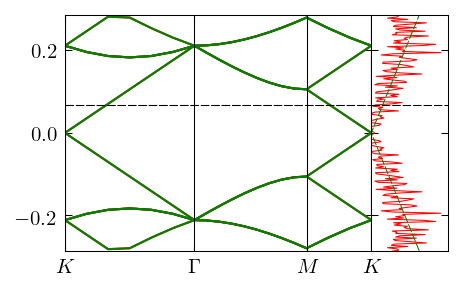

In [18]:

e_lims = -np.amax(tblg.band_structure.energies),np.amax(tblg.band_structure.energies) #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
dosvals = tblg.dos(e_vals, shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c='r',emin = e_lims[0], emax=e_lims[1])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'],c='g',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
#plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot(abs(e_vals)*4/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

# Static polarization

In [19]:
chi = np.zeros([len(q_sample)], dtype = float)
chi_gr = np.zeros([len(q_sample)], dtype = float)
for i in tqdm(range(len(q_sample))):
    chi[i] =np.real(tblg.static_polarization(q_index = i, G_index = 0, G1_index = 0, use_bands = slice(None,None,None),eta =0))
    chi_gr[i] = 2. * np.real(gr.chi(omega = 0, q = np.linalg.norm(q_sample.get_coords(i)), Ef= tblg.band_structure.chemical_potential))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\crystal\analysis\polarization_functions.py:7: RuntimeWarning: invalid value encountered in true_divide
  prefactor = occupation_diff * energy_diff/ (energy_diff**2 +eta**2)
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  Dplus  = (omega/hv_F + 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  Dminus = (omega/hv_F - 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  it1 = 8.*k_F/(hv_F*q*q)
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\no

In [20]:
contour = q_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])

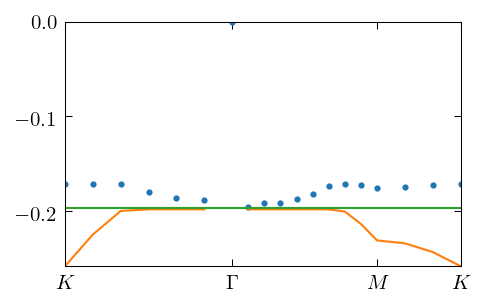

In [21]:
plt.plot(contour['x'], chi[contour['indices']],'o')
plt.plot(contour['x'], chi_gr[contour['indices']])
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
tblg.eta=tblg.band_structure.temperature
plt.plot(contour['x'], -np.ones_like(contour['x'])*tblg.dos(tblg.band_structure.chemical_potential,shape = 'fermi'))

(-0.12353678914669539,
 0.1389788877900323,
 -1.3877787807814457e-17,
 0.32095799310899975)

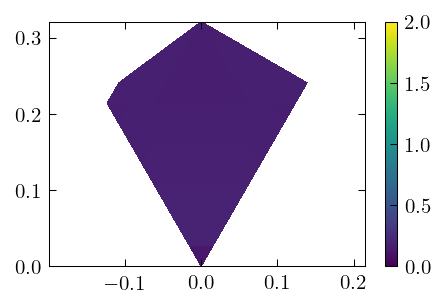

C:\Users\Windows\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


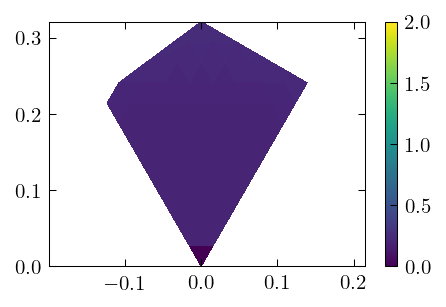

In [22]:
plt.figure()
plt.tripcolor(
q_sample.coords[:,0],
q_sample.coords[:,1],
-chi,
vmin=0,
vmax = 2
)
plt.colorbar()
plt.axis('equal')

plt.figure()
plt.tripcolor(
q_sample.coords[:,0],
q_sample.coords[:,1],
-chi_gr,
vmin=0,
vmax = 2
)
plt.colorbar()
plt.axis('equal')

# Dynamic polarization

In [23]:
omega_vals = np.linspace(0,.3,num=200)
chi2D = np.zeros([len(contour['indices']),len(omega_vals)], dtype = float)
for i in tqdm(range(len(contour['indices']))):
        chi2D[i,:] =np.imag(tblg.polarization(omega = omega_vals +0.01j, q_index = contour['indices'][i], G_index = 0, G1_index = 0))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.86it/s]


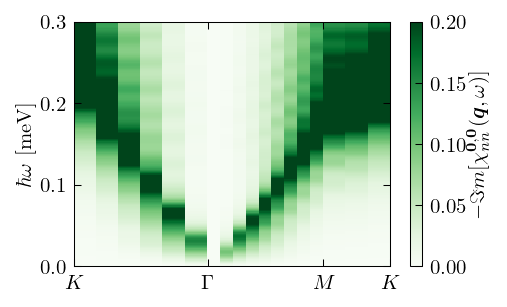

In [24]:
XX, YY = np.meshgrid(contour['x'], omega_vals)
plt.pcolormesh(XX,YY,-chi2D.T,shading = 'nearest',vmin = 0,vmax = .2,cmap = 'Greens')
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
plt.ylabel(r'$\hbar \omega ~[{\rm meV}]$')
cb = plt.colorbar()
cb.set_label(r'$-\Im m[ \chi_{nn}^{\bm 0, \bm 0}(\bm q,\omega)]$')

In [25]:
sigma_vals = tblg.local_conductivity(omega_vals)[:,0,0]

C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


In [26]:
chi_local = np.zeros([len(contour['indices']),len(omega_vals)], dtype = float)
for i in tqdm(range(len(contour['indices']))):
    q = np.linalg.norm(q_sample.get_coords(contour['indices'][i]))
    chi_local[i,:] =- q**2/(np.pi * omega_vals) *np.real(sigma_vals)

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]C:\Users\Windows\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Windows\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3170.42it/s]


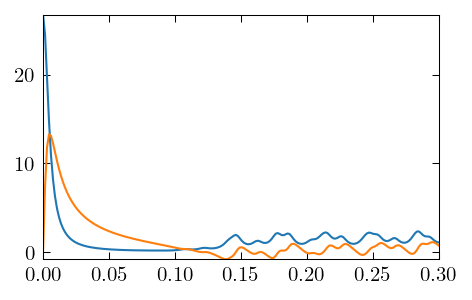

In [27]:
plt.plot(omega_vals,sigma_vals.real)
plt.plot(omega_vals,sigma_vals.imag)

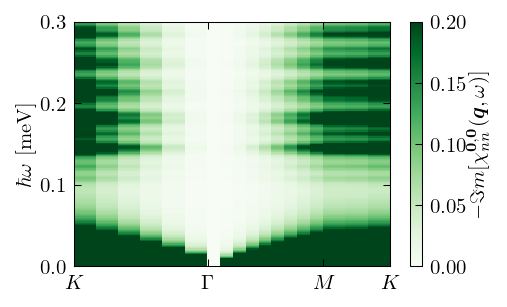

In [28]:
XX, YY = np.meshgrid(contour['x'], omega_vals)
plt.pcolormesh(XX,YY,-chi_local.T,shading = 'nearest',vmin = 0,vmax = .2,cmap = 'Greens')
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
plt.ylabel(r'$\hbar \omega ~[{\rm meV}]$')
cb = plt.colorbar()
cb.set_label(r'$-\Im m[ \chi_{nn}^{\bm 0, \bm 0}(\bm q,\omega)]$')

# Compare with graphene polarization

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:58: RuntimeWarning: divide by zero encountered in true_divide
  Dplus  = (omega/hv_F + 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:59: RuntimeWarning: divide by zero encountered in true_divide
  Dminus = (omega/hv_F - 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  it1 = 8.*k_F/(hv_F*q*q)
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:52: RuntimeWarning: invalid value encountered in multiply
  sz2m1 = np.sqrt(z-1.)*np.sqrt(z+1.)
C:\Users\Windows\Dropbox\ICFO\python_projects\pybandstructure-notebooks\notebooks\graphene.py:53: RuntimeWarning: invalid va

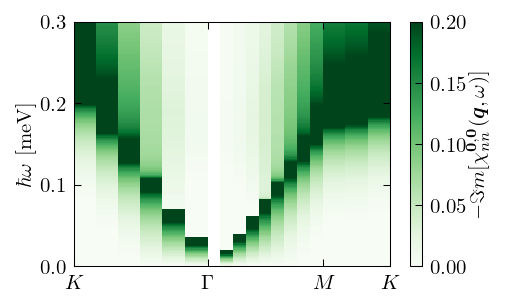

In [29]:
omega_vals = np.linspace(0,.3,num=200)
chi2D_gr = np.zeros([len(contour['indices']),len(omega_vals)], dtype = float)
for i in tqdm(range(len(contour['indices']))):
        chi2D_gr[i,:] =2. * np.imag(gr.chi(omega = omega_vals, q = np.linalg.norm(q_sample.get_coords(contour['indices'][i])), Ef= tblg.band_structure.chemical_potential))
plt.pcolormesh(XX,YY,-chi2D_gr.T,shading = 'nearest',vmin = 0,vmax = .2,cmap = 'Greens')
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
plt.ylabel(r'$\hbar \omega ~[{\rm meV}]$')
cb = plt.colorbar()
cb.set_label(r'$-\Im m[ \chi_{nn}^{\bm 0, \bm 0}(\bm q,\omega)]$')